### Import Base Model with new top model and frozen layers

In [1]:
#import ResNet50finetune
import VGG16finetune
import h5py

Using TensorFlow backend.


In [4]:
final_model_orig = ResNet50finetune.ResNet50finetune()
final_model_fine = ResNet50finetune.ResNet50finetune()

K.image_dim_ordering: tf
K.image_dim_ordering: tf


In [5]:
weights_path = 'Caffe models/ResNet50/weights/ResNet50-finetune5-14-0.66.h5'
f = h5py.File(weights_path)

In [27]:
k = 171
name = f.attrs['layer_names'][k]
print name
weights = [f[name][h][()] for h in f[name].keys()]
final_model_fine.layers[k].set_weights(weights)


bn5c_branch2c


In [28]:
final_model_fine.layers[k].get_weights()

[array([-1.45125782, -1.65197432, -1.63190234, ..., -1.60618222,
        -1.72180915, -1.93755329], dtype=float32),
 array([ 1.3451786 ,  1.39657283,  1.4453218 , ...,  1.20929563,
         1.59697223,  1.43210948], dtype=float32),
 array([-0.12825978, -0.0863668 , -0.07194976, ..., -0.05564213,
        -0.03709351, -0.0422993 ], dtype=float32),
 array([ 0.0099396 ,  0.00943395,  0.01045332, ...,  0.00850692,
         0.01214169,  0.00997391], dtype=float32)]

In [29]:
final_model_orig.layers[k].get_weights()

[array([ 1.3451786 ,  1.39657283,  1.4453218 , ...,  1.20929563,
         1.59697223,  1.43210948], dtype=float32),
 array([-1.45125782, -1.65197432, -1.63190234, ..., -1.60618222,
        -1.72180915, -1.93755329], dtype=float32),
 array([-0.12825978, -0.0863668 , -0.07194976, ..., -0.05564213,
        -0.03709351, -0.0422993 ], dtype=float32),
 array([ 0.0099396 ,  0.00943395,  0.01045332, ...,  0.00850692,
         0.01214169,  0.00997391], dtype=float32)]

In [7]:
for k in range(len(f.attrs['layer_names'])): 
    name = f.attrs['layer_names'][k]
    weights = [f[name][h][()] for h in f[name].keys()]
    print k
    final_model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

175
176
177
178
Model loaded.


### Make object from Model to be Finetuned

In [2]:
import tensorflow as tf

In [2]:
#final_model = ResNet50finetune.ResNet50finetune()
#with tf.device('/gpu:1'):
final_model = VGG16finetune.VGG16finetune()

In [3]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [4]:
from keras import optimizers

In [5]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

### Directory to Training and Val images 
Used for ImageDataGenerator

In [6]:
train_data_dir = 'kaggle/Training'#TrainingRandCrop
validation_data_dir = 'kaggle/Validation'
nb_train_samples = 1032
nb_validation_samples = 688
nb_epoch = 45

img_height = 224
img_width = 224

In [7]:
from keras.callbacks import ModelCheckpoint

In [8]:
from keras.preprocessing.image import ImageDataGenerator


My ImageDataGenerator that random crops images

In [8]:
from myimage import load_dataset

In [9]:
train_generator = load_dataset(train_data_dir,(1000,1000),batch_size=32)

validation_generator = load_dataset(validation_data_dir,(1000,1000),batch_size=32)

In [ ]:
#with tf.device('/gpu:1'):
# prepare data augmentation configuration
# Rescale Images
# Sample wise mean center
# Flip images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        samplewise_center = True)

test_datagen = ImageDataGenerator(rescale=1./255, samplewise_center = True)


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=32)

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=32)


# File to save weights every 5 epochs
file_path = 'Caffe models/VGG/VGG16-finetune8less-{epoch:02d}-{val_acc:.2f}.h5'
checkpoint = ModelCheckpoint(file_path, verbose=1, save_weights_only=True, period=5)
callbacks_list = [checkpoint]


# fine-tune the model
history = final_model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples,
        callbacks=callbacks_list)

Found 1032 images belonging to 344 classes.
Found 688 images belonging to 344 classes.
Epoch 1/45


### Plot the History of Training

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
result = history.history

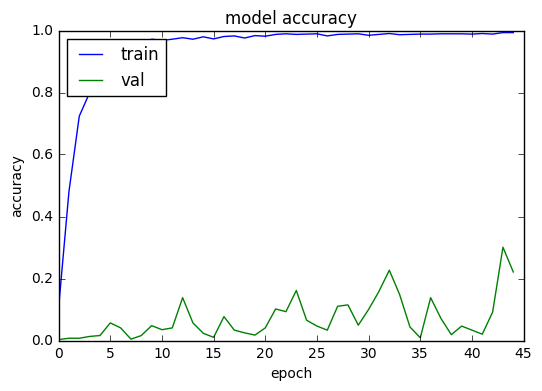

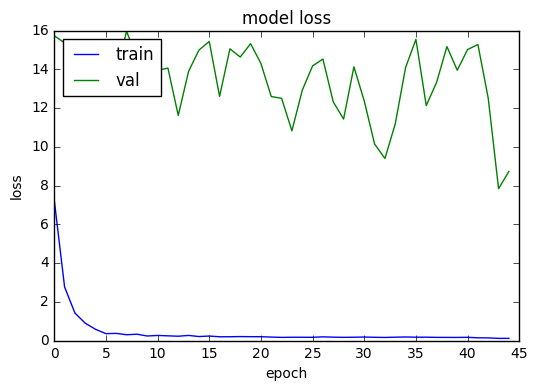

In [12]:
# summarize history for accuracy
plt.plot(result['acc'])
plt.plot(result['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result['loss'])
plt.plot(result['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()